# Cross validation and grid search


<b>About the two datasets used</b>

<u>Context</u>

Superheroes have been in popular culture for a long time, and now more than ever. Since its creation, superheroes have not been diverse, but this is changing rapidly. The two datasets aim to provide an overview of heroes and their physical and power characteristics, helping curious people to identify trends and patterns. In this case, we want to understand how physical attributes and powers define superheroes' alignment (superhero, supervillain).

In [ ]:
import pandas as pd

df_physical_traits = pd.read_csv('https://raw.githubusercontent.com/jnin/information-systems/refs/heads/main/data/superheroes_superpowers.csv', index_col=False)
df_superpowers = pd.read_csv(' https://raw.githubusercontent.com/jnin/information-systems/refs/heads/main/data/superheroes_%20physical_traits.csv', index_col=False)

### Combining & pre-processing the data

In this step we are combing the two datasets on `Name` and `Publisher` and set the target variables.

In [117]:
df_physical_traits.rename(columns={'name': 'Name'}, inplace=True)
df = pd.merge(df_superpowers, df_physical_traits, on=['Name', 'Publisher'])

df.value_counts('Publisher').head() / df.shape[0]

Publisher
Marvel Comics        0.527048
DC Comics            0.302937
NBC - Heroes         0.027821
Dark Horse Comics    0.027821
Image Comics         0.021638
Name: count, dtype: float64

We decided to drop the following columns:

- **Alignment** since it's the target variable, mapped `0` for the superhero being `good` and `1` for it being `bad`
- **Eye color, Hair color, Skin color:**
- **Publisher, Name:** since the name & publisher of the superhero are highly individual, irrelevant criteria for prediction. Furthermore the distribution for Publishers is highly skewed with 50% + 30% of the heros being published by Marvel and DC respectively
- **Race:** since has been shown in an initial RFC to not be a valid predictor (plus would not be permissible in real life)

In [109]:
print(df['Alignment'].value_counts())
df = df[df['Alignment'] != 'neutral']

target = 'Alignment'

y = df[target]
y = df[target].map({'good': 0, 'bad': 1})

X = df.drop(columns=[target, 'Eye color', 'Hair color', 'Skin color', 'Publisher', 'Name', 'Race'])

Alignment
good    424
bad     193
Name: count, dtype: int64


We then count any **missing values** to check, which columns need to be imputed. In the last step the cleaned feature set is being displayed before moving on to the **preprocessing pipeline**

In [121]:
missing_per_column = X.isnull().sum()
print('There are missing values in the following columns:')
print(missing_per_column[missing_per_column > 0]) # only print columns with missing values

X.head()

There are missing values in the following columns:
Gender    14
dtype: int64


,Gender,Height,Weight,Has Superpowers,Power Level,Intelligence Level,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
0,Male,203.0,441.0,False,Extremely Powerful,Super-Genius,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Male,191.0,65.0,True,Below Average,Average Intelligence,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Male,185.0,90.0,True,Average,Low Intelligence,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,Male,203.0,441.0,False,Extremely Powerful,Smart,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Male,-99.0,-99.0,False,Extremely Powerful,Genius,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


### Setting up the preprocessing Pipeline

In this step we assign the columns to different categories to further process them according to their content.

##### 1. Imputation
Since only `Gender`had missing values, this is the only imputation target for now. However, to ensure operationalization and stability for future incoming data (which might not be as clean), we include `Weight`and `Height` as well, with an initial `strategy` set to `median`.

For `Gender` we go with the `most_frequent` strategy, since the outcome has to be binary.


##### 2. Encoding ordinal and categorical columns

The **ordinal columns** for `Power Level`and `Intelligence Level` are encoded using the `OrdinalEncoder` according to their corresponding `categories` ranking to ensure the correct order.

The only **categorical column** is `Gender` which has been imputed in the previous step and is encoded using the `OneHotEncoder`

##### 3. Scaling

The `Weight` and `Height` columns are then scaled using the `StandardScaler` to facilitate processing and improve performance. Since all other columns have been encoded either ordinally or binary, no further scaling is needed.

#### 4. Instantiating the Preprocessing Pipeline

As last step the ColumnTransformers `imputing`, `encoding` and `scaling` are passed as steps to a preprocessing pipeline, which will be integrated into the model pipeline in the next search to enable the GridSearch.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


imputing = ColumnTransformer(
    [('impute_wh', SimpleImputer(strategy='median'), ['Weight', 'Height']),
     ('impute_categorical', SimpleImputer(strategy='most_frequent'), ['Gender'])],
    remainder="passthrough",
    force_int_remainder_cols=False,
    verbose_feature_names_out=False
)

categorical_cols = ['Gender']
ordinal_cols = ['Power Level', 'Intelligence Level']

categories = [
    ['Weak', 'Below Average', 'Average', 'Above Average', 'Extremely Powerful'],
    ['Low Intelligence', 'Average Intelligence', 'Smart', 'Genius', 'Super-Genius']
]

encoding = ColumnTransformer(
    [('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols),
     ('ord_enc', OrdinalEncoder(categories=categories), ordinal_cols)],
    remainder="passthrough",
    force_int_remainder_cols=False,
    verbose_feature_names_out=False
)

scaling = ColumnTransformer(
    [('scaler', StandardScaler(), ['Weight', 'Height'])],
    remainder='passthrough',
    force_int_remainder_cols=False,
    verbose_feature_names_out=False
)

processing_steps = [
    ('imputer', imputing),
    ('encoder', encoding),
    ('scaler', scaling)
]

pre_pipe = Pipeline(processing_steps)

### Creating a baseline RFC model to evaluate feature importances and re-iterate on the feature selection

The 10 MOST IMPORTANT features are:


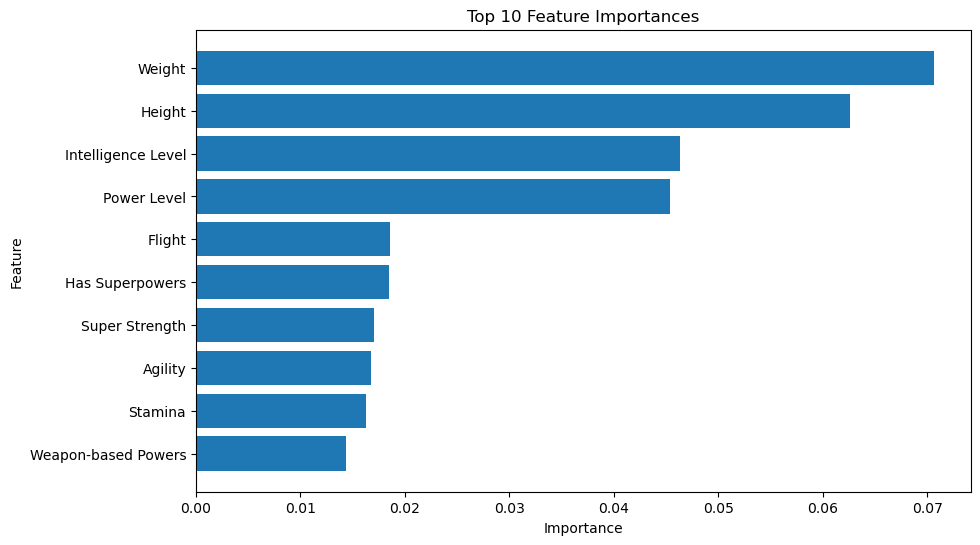

The 10 LEAST IMPORTANT features are:


,Feature,Importance
6,Race_Amazon,0.000009
144,Nova Force,0.000008
18,Race_Eternal,0.000003
171,Thirstokinesis,0.000000
224,Speed Force,0.000000
39,Race_Martian,0.000000
164,Banish,0.000000
227,Vision - Cryo,0.000000
228,Omnipresent,0.000000
229,Omniscient,0.000000


In [105]:

from sklearn.ensemble import RandomForestClassifier

X_transformed = pre_pipe.fit_transform(X)
rfc = RandomForestClassifier()

rfc.fit(X_transformed, y)

feature_importances = rfc.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_transformed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.gca().invert_yaxis()  # Invert y-axis to display the most important on top
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
print('The 10 MOST IMPORTANT features are:')
plt.show()

print('The 10 LEAST IMPORTANT features are:')
display(importance_df.tail(10))

### Importing models and defining the parameter grid

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


param_grids = [
    {
        'classifier': [LogisticRegression()],
        'pre__imputer__impute_wh__strategy': ['median', 'mean'],
        'classifier__solver': ['lbfgs'],
        'classifier__C': [0.8, 1.0],
        'classifier__class_weight': ['balanced', None],
        'classifier__max_iter': [1000] 
    },
    {
        'classifier': [SVC()],
        'pre__imputer__impute_wh__strategy': ['median', 'mean'],
        'classifier__C': [0.1, 1.0, 10],
        'classifier__kernel': ['rbf', 'poly'],  
        'classifier__gamma': ['scale', 0.1, 50]  
    },
    {
        'classifier': [RandomForestClassifier()],
        'pre__imputer__impute_wh__strategy': ['median', 'mean'],
        'classifier__n_estimators': [100, 200, 300], 
        'classifier__max_depth': [None, 7, 10], 
        'classifier__max_features': ['sqrt', 'log2'] 
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'pre__imputer__impute_wh__strategy': ['median', 'mean'],
        'classifier__max_depth': [None, 5, 7, 10],  
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__splitter': ['best', 'random']  
    },
    {
        'classifier': [XGBClassifier(eval_metric='logloss')],
        'pre__imputer__impute_wh__strategy': ['median', 'mean'],
        'classifier__n_estimators': [100, 200], 
        'classifier__max_depth': [3, 5, 7], 
        'classifier__learning_rate': [0.1, 0.05], 
    }
]

### Testing different models & predictions

The model code runs for about **10 minutes**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('pre', pre_pipe),
    ('classifier', LogisticRegression())
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grids,
    cv=5,
    scoring='recall',
    verbose = 2,
    error_score='raise'
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 136 candidates, totalling 680 fits
[CV] END classifier=LogisticRegression(), classifier__C=0.8, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__solver=lbfgs, pre__imputer__impute_weight__strategy=median; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.8, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__solver=lbfgs, pre__imputer__impute_weight__strategy=median; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.8, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__solver=lbfgs, pre__imputer__impute_weight__strategy=median; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.8, classifier__class_weight=balanced, classifier__max_iter=1000, classifier__solver=lbfgs, pre__imputer__impute_weight__strategy=median; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.8, classifier__class_we

c:\Users\tsach\miniconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('pre',
                                        Pipeline(steps=[('imputer',
                                                         ColumnTransformer(force_int_remainder_cols=False,
                                                                           remainder='passthrough',
                                                                           transformers=[('impute_weight',
                                                                                          SimpleImputer(strategy='median'),
                                                                                          ['Weight']),
                                                                                         ('impute_categorical',
                                                                                          SimpleImputer(strategy='most_frequent'),
                                                                                          ['Gender'])],
                                                                           verbose_feature_names_out=Fa...
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       multi_strategy=None,
                                                       n_estimators=None,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=None, ...)],
                          'classifier__learning_rate': [0.1, 0.05],
                          'classifier__max_depth': [3, 5, 7],
                          'classifier__n_estimators': [100, 200],
                          'pre__imputer__impute_weight__strategy': ['median',
                                                                    'mean']}],
             scoring='recall', verbose=2)

### Comparing all parameters

In [ ]:
results = grid.cv_results_

model_scores = pd.DataFrame({
    'model': [type(params['classifier']).__name__ for params in results['params']],
    'mean_accuracy': results['mean_test_score'],
    'model_rank': results['rank_test_score']
})

model_scores = model_scores.sort_values(by='model_rank')
display(model_scores[:10])

,model,mean_accuracy,model_rank
0,LogisticRegression,0.542366,1
1,LogisticRegression,0.542366,1
4,LogisticRegression,0.542151,3
5,LogisticRegression,0.542151,3
96,DecisionTreeClassifier,0.437634,5
80,DecisionTreeClassifier,0.424301,6
82,DecisionTreeClassifier,0.412473,7
83,DecisionTreeClassifier,0.412258,8
97,DecisionTreeClassifier,0.398925,9
81,DecisionTreeClassifier,0.391183,10


### Finding the best parameters

In [ ]:
# Best model details
best_model = grid.best_estimator_
best_model_name = type(best_model.named_steps['classifier']).__name__

best_model_info = {
    'model': best_model_name,
    'params': grid.best_params_,
    'mean_test_accuracy': grid.best_score_
}

# Evaluate the best model on train and test sets
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

# Collect train and test scores for the best model
scores = {
    'model': best_model_name,
    'params': grid.best_params_,
    'train_accuracy': accuracy_score(y_train, train_preds),
    'train_precision': precision_score(y_train, train_preds, average='weighted', zero_division=0),
    'train_recall': recall_score(y_train, train_preds, average='weighted', zero_division=0),
    'train_f1': f1_score(y_train, train_preds, average='weighted', zero_division=0),
    'test_accuracy': accuracy_score(y_test, test_preds),
    'test_precision': precision_score(y_test, test_preds, average='weighted', zero_division=0),
    'test_recall': recall_score(y_test, test_preds, average='weighted', zero_division=0),
    'test_f1': f1_score(y_test, test_preds, average='weighted', zero_division=0)
}

# Create a detailed DataFrame for the best model
final_scores = pd.DataFrame([scores])
display(final_scores.T)

,0
model,LogisticRegression
params,"{'classifier': LogisticRegression(), 'classifi..."
train_accuracy,0.787018
train_precision,0.816907
train_recall,0.787018
train_f1,0.793597
test_accuracy,0.596774
test_precision,0.653058
test_recall,0.596774
test_f1,0.609852
